In [26]:
import pandas as pd
import numpy as np

from scipy import stats

import json
import clustering
from clustering.what_if_model import WhatIfModel
from clustering.pqp_input_parser import PQPInputParser
from clustering.util import create_model
import autoreload
import clustering.evaluation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
BASE_PATH_TPCH = "~/Dokumente/repos/example_plugin/stats/final/tpch/sf1-2d/"
TPCH_ORDERKEY = f"{BASE_PATH_TPCH}/l_orderkey"
TPCH_SHIPDATE = f"{BASE_PATH_TPCH}/l_shipdate"

In [28]:
m = create_model("lineitem", PQPInputParser("tpch", TPCH_ORDERKEY), 2)

cost_model_output/models/


In [ ]:
m.suggest_clustering(30)

In [66]:
CLUSTERING_COLUMN = "l_shipdate"
SIDED = False
join_results = clustering.evaluation.evaluate_join_step(m, TPCH_SHIPDATE, [CLUSTERING_COLUMN], CLUSTERING_COLUMN, [100], "ALL", SIDED)


print(f"There are {len(join_results)} joins")
join_results[['QUERY_HASH1', 'DESCRIPTION1', 'RUNTIME_BASE', 'RUNTIME_ESTIMATE', 'RUNTIME_CLUSTERED', 'TOTAL_ERROR', 'RELATIVE_ERROR']]

## Estimating ColumnBetween scans
dropping columns COLUMN_TYPE_983025.0
## Estimating ColumnVsValue scans
adding column PREDICATE_GreaterThan
adding column PREDICATE_GreaterThanEquals
adding column PREDICATE_NotEquals

## Estimating REFERENCE DATA joins
adding column PROBE_INPUT_COLUMN_SORTED_No
dropping columns PROBE_INPUT_COLUMN_SORTED_Ascending
## Estimating REFERENCE REFERENCE joins
dropping columns PROBE_INPUT_COLUMN_SORTED_Ascending

There are 769 joins


,QUERY_HASH1,DESCRIPTION1,RUNTIME_BASE,RUNTIME_ESTIMATE,RUNTIME_CLUSTERED,TOTAL_ERROR,RELATIVE_ERROR
0,10a29f9a2f853b35,JoinHash (Inner Join where ps_partkey = p_part...,287764,359264,294749,-64515,0.820425
1,10a29f9a2f853b35,JoinHash (Inner Join where ps_suppkey = s_supp...,252702,359264,257591,-101673,0.716996
2,10a29f9a2f853b35,JoinHash (Inner Join where s_nationkey = n_nat...,161693,156726,161624,4898,1.031252
3,10a29f9a2f853b35,JoinHash (Semi Join where n_regionkey = r_regi...,61813,104357,62651,-41706,0.600353
4,10a29f9a2f853b35,JoinHash (Semi Join where n_regionkey = r_regi...,60906,116533,59020,-57513,0.506466
5,10a29f9a2f853b35,JoinHash (Semi Join where ps_partkey = p_partk...,2105152,2627674,2085316,-542358,0.793598
6,10a29f9a2f853b35,JoinHash (Semi Join where ps_suppkey = s_suppk...,451273,517565,464195,-53370,0.896883
7,10a29f9a2f853b35,JoinHash (Semi Join where ps_suppkey = s_suppk...,346924,517565,335749,-181816,0.648709
8,10a29f9a2f853b35,JoinHash (Semi Join where s_nationkey = n_nati...,175592,222541,174685,-47856,0.784956
9,10a29f9a2f853b35,JoinHash (Semi Join where s_nationkey = n_nati...,169935,205190,169725,-35465,0.827160


There are 769 operators

68% of the operator estimates are over- or underestimated between factor 1 and 1.5
22% of the operator estimates are over- or underestimated between factor 1.5 and 3
9% of the operator estimates are over- or underestimated between factor 3 and 100

Total estimate: 38167 ms
Total measured: 26107 ms
MSE: 1568 ms^2
SMAPE: 39%


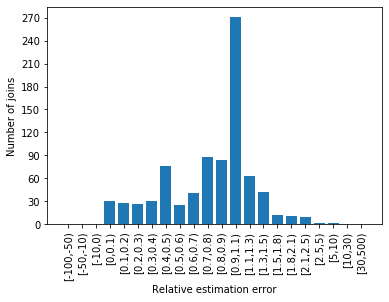

In [68]:
clustering.evaluation.print_aggregated_metrics(join_results, m.query_frequencies)
clustering.evaluation.plot_join_errors(join_results, m.query_frequencies)

In [74]:
CLUSTERING_COLUMN = "l_shipdate"
scan_results = clustering.evaluation.evaluate_scans(m, TPCH_SHIPDATE, [CLUSTERING_COLUMN], CLUSTERING_COLUMN, [100])
print(f"There are {len(scan_results)} scans on {m.table_name}")

scan_results[['QUERY_HASH', 'DESCRIPTION1', 'RUNTIME_BASE', 'RUNTIME_ESTIMATE', 'RUNTIME_CLUSTERED', 'rti', 'TOTAL_ERROR', 'RELATIVE_ERROR']].sort_values(['TO'], ascending=False)

## Estimating ColumnBetween scans
dropping columns COLUMN_TYPE_983025.0
## Estimating ColumnVsValue scans
adding column PREDICATE_GreaterThan
adding column PREDICATE_GreaterThanEquals
adding column PREDICATE_NotEquals

## Estimating REFERENCE DATA joins
adding column PROBE_INPUT_COLUMN_SORTED_No
dropping columns PROBE_INPUT_COLUMN_SORTED_Ascending
## Estimating REFERENCE REFERENCE joins
dropping columns PROBE_INPUT_COLUMN_SORTED_Ascending

There are 91 scans on lineitem


,QUERY_HASH,DESCRIPTION1,RUNTIME_BASE,RUNTIME_ESTIMATE,RUNTIME_CLUSTERED,rti,TOTAL_ERROR,RELATIVE_ERROR
34,60b9fcce6fd0723e,TableScan Impl: ColumnBetween l_shipdate BETWE...,15645038,1837223,364386,2.264136,-1472837,0.198335
10,45337615a2f78d4e,TableScan Impl: ColumnBetween l_shipdate BETWE...,16103436,1837223,345876,2.330475,-1491347,0.188260
37,6cf267cd7600d268,TableScan Impl: ColumnBetween l_shipdate BETWE...,15901511,1815173,314096,2.299667,-1501077,0.173039
18,522ef8893e703a3a,TableScan Impl: ColumnBetween l_shipdate BETWE...,16012846,1836918,309207,2.317119,-1527711,0.168329
47,8368ab7c633a1ab2,TableScan Impl: ColumnBetween l_shipdate BETWE...,15783891,1836918,298590,2.284231,-1538328,0.162549
64,c074ef7db223ee78,TableScan Impl: ColumnBetween l_shipdate BETWE...,15945096,1815173,290069,2.305970,-1525104,0.159802
14,497648c7e308ba08,TableScan Impl: ColumnBetween l_shipdate BETWE...,15998108,1816516,272329,2.313143,-1544187,0.149918
43,7994976cdc25c131,TableScan Impl: ColumnBetween l_shipdate BETWE...,15881746,1836918,265833,2.298149,-1571085,0.144717
86,f407b6343e686343,TableScan Impl: ColumnBetween l_shipdate BETWE...,15851992,1836918,256404,2.293843,-1580514,0.139584
58,9f3c5fc752625649,TableScan Impl: ColumnBetween l_shipdate BETWE...,10350867,1037550,207373,1.702740,-830177,0.199868


There are 91 operators

50% of the operator estimates are over- or underestimated between factor 1 and 1.5
6% of the operator estimates are over- or underestimated between factor 1.5 and 3
42% of the operator estimates are over- or underestimated between factor 3 and 100

Total estimate: 362 ms
Total measured: 275 ms
MSE: 4 ms^2
SMAPE: 70%


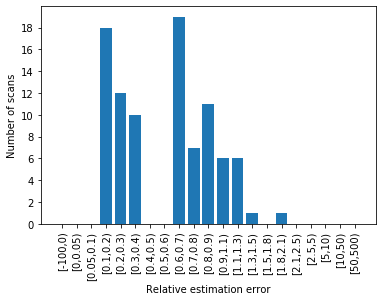

In [75]:
clustering.evaluation.print_aggregated_metrics(scan_results, m.query_frequencies)
clustering.evaluation.plot_scan_errors(scan_results, m.query_frequencies)